# MLOps - Lab 3

Dawid Stachowiak 141171

In [39]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.onnx
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models.resnet import ResNet, BasicBlock

training_device = torch.device('mps' if torch.mps.is_available() else 'cpu')
inference_device = "cpu" # We don't use MPS for reliable comparison (not all optimizations works with MPS)

### Baseline preparation

In [2]:
def measure_time_and_accuracy(model: nn.Module, data_loader: DataLoader, device):
    model.eval()
    model.to(device)
    total_time = 0
    total_correct = 0
    total_images = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            start_time = time.time()
            outputs = model(images)
            end_time = time.time()

            total_time += end_time - start_time
            total_images += images.size(0)

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
    
    avg_inference_time = total_time / total_images
    accuracy = total_correct / total_images
    return avg_inference_time, accuracy


In [3]:
# Define transformations for the training and test sets
transform = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=2
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def get_model():
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)

    for name, param in model.named_parameters():
        if "fc" not in name:
            param.requires_grad = False

    model.to(inference_device)
    return model

model = get_model()

/Users/dawid/Private/School/Sem 2/MLOps/Lab1/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dawid/Private/School/Sem 2/MLOps/Lab1/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

# num_epochs = 10 
# model.to(training_device)

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0

#     for inputs, labels in train_loader:
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()

#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')
  
# torch.save(model.state_dict(), 'resnet18_cifar10.pth')

In [5]:
model.load_state_dict(torch.load('resnet18_cifar10.pth'))

avg_time, accuracy = measure_time_and_accuracy(model, test_loader, inference_device)
print(f'Average inference time: {avg_time:.6f} seconds')
print(f'Accuracy: {accuracy:.2f}')

/var/folders/9y/cmlwz0zs6z927_wq72404vd40000gn/T/ipykernel_70320/3692674384.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18_ci

Average inference time: 0.015987 seconds
Accuracy: 0.81


## Pruning

#### Weights - Unstructured Pruning

In [6]:
import torch.nn.utils.prune as prune

def apply_global_pruning(model, amount):
    parameters_to_prune = []
    for _, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )

    for _, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            prune.remove(module, 'weight')

    return model

model = get_model()
model.load_state_dict(torch.load('resnet18_cifar10.pth'))
model = apply_global_pruning(model, amount=0.3)

/var/folders/9y/cmlwz0zs6z927_wq72404vd40000gn/T/ipykernel_70320/1146981061.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18_c

In [7]:
weights_pruned_avg_time, weights_pruned_accuracy = measure_time_and_accuracy(model, test_loader, inference_device)

In [8]:
print(f'Average inference time (weights pruned): {weights_pruned_avg_time:.6f} seconds')
print(f'Accuracy (weights pruned): {weights_pruned_accuracy:.2f}')

Average inference time (weights pruned): 0.015826 seconds
Accuracy (weights pruned): 0.79


#### Layers - Structured Pruning

In [16]:
class PrunedResNet18(ResNet):
    def __init__(self, num_classes=10):
        super(PrunedResNet18, self).__init__(block=BasicBlock, layers=[2, 1, 1, 1])  # Reduce layers
        self.fc = nn.Linear(model.fc.in_features, num_classes)

layer_pruned_model = PrunedResNet18(num_classes=10)
layer_pruned_model = layer_pruned_model.to(inference_device)

In [17]:
# Transfer the weights from the the new model to pruned model
baseline_state_dict = torch.load('resnet18_cifar10.pth')
pruned_state_dict = layer_pruned_model.state_dict()

for name in pruned_state_dict.keys():
    if name in baseline_state_dict and pruned_state_dict[name].shape == baseline_state_dict[name].shape:
        pruned_state_dict[name] = baseline_state_dict[name]

layer_pruned_model.load_state_dict(pruned_state_dict)

/var/folders/9y/cmlwz0zs6z927_wq72404vd40000gn/T/ipykernel_70320/3483090983.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  baseline_state_dict = torch.load('resnet18_ci

<All keys matched successfully>

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(layer_pruned_model.parameters(), lr=0.001, momentum=0.9)
epochs = 5
pruned_model = layer_pruned_model.to(training_device)

for epoch in range(epochs):
    layer_pruned_model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(training_device)
        labels = labels.to(training_device)

        optimizer.zero_grad()

        outputs = layer_pruned_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f'Layer-Pruned Model Fine-tune Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

torch.save(layer_pruned_model.state_dict(), 'resnet18_cifar10_layer_pruned_fine_tuned.pth')

Layer-Pruned Model Fine-tune Epoch 1/5, Loss: 1.4761
Layer-Pruned Model Fine-tune Epoch 2/5, Loss: 0.9976
Layer-Pruned Model Fine-tune Epoch 3/5, Loss: 0.7919
Layer-Pruned Model Fine-tune Epoch 4/5, Loss: 0.6585
Layer-Pruned Model Fine-tune Epoch 5/5, Loss: 0.5656


In [28]:
layer_pruned_avg_time, layer_pruned_accuracy = measure_time_and_accuracy(layer_pruned_model, test_loader, inference_device)

In [29]:
print(f'Average inference time (weights and layer pruned): {layer_pruned_avg_time:.6f} seconds')
print(f'Accuracy (weights and layer pruned): {layer_pruned_accuracy:.2f}')

Average inference time (weights and layer pruned): 0.010797 seconds
Accuracy (weights and layer pruned): 0.82


#### Pruning Results

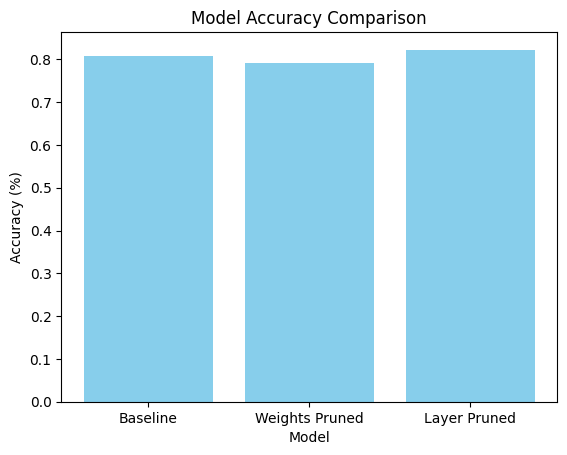

In [36]:
model_names = ['Baseline', 'Weights Pruned', 'Layer Pruned']
accuracies = [accuracy, weights_pruned_accuracy, layer_pruned_accuracy]

plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.show()


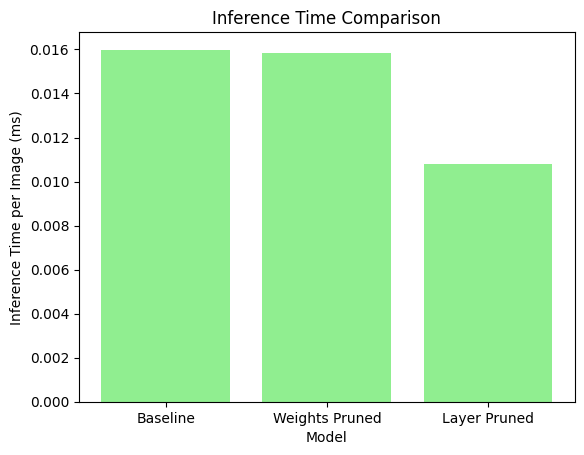

In [37]:
inference_times = [avg_time, weights_pruned_avg_time, layer_pruned_avg_time]

plt.bar(models, inference_times, color='lightgreen')
plt.xlabel('Model')
plt.ylabel('Inference Time per Image (ms)')
plt.title('Inference Time Comparison')
plt.show()

### Quantization

In [55]:
torch.backends.quantized.engine = 'qnnpack'

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)
model.load_state_dict(torch.load('resnet18_cifar10.pth', map_location=inference_device))

# Apply dynamic quantization
quantized_model = torch.quantization.quantize_dynamic(model, dtype=torch.qint8)

/var/folders/9y/cmlwz0zs6z927_wq72404vd40000gn/T/ipykernel_70320/1053876449.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resnet18_ci

In [56]:
quantized_model_avg_time, quantized_model_accuracy = measure_time_and_accuracy(quantized_model, test_loader, inference_device)

In [57]:
print(f'Quantized (PyTorch) Model Accuracy: {quantized_model_accuracy:.2f}%')
print(f'Quantized (PyTorch) Inference Time per Image: {quantized_model_avg_time:.6f} seconds')

Quantized (PyTorch) Model Accuracy: 0.81%
Quantized (PyTorch) Inference Time per Image: 0.014840 seconds


#### Quantization Results

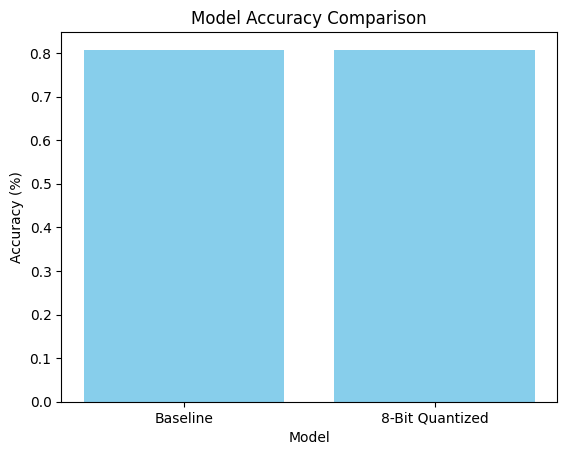

In [54]:
model_names = ['Baseline', '8-Bit Quantized']
accuracies = [accuracy, quantized_model_accuracy]

plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.show()

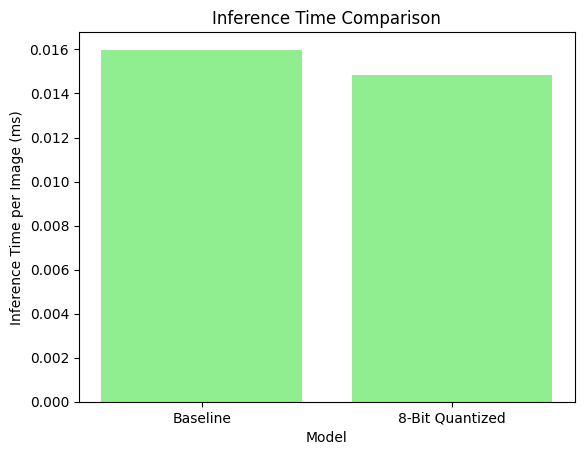

In [58]:
inference_times = [avg_time, quantized_model_avg_time]

plt.bar(model_names, inference_times, color='lightgreen')
plt.xlabel('Model')
plt.ylabel('Inference Time per Image (ms)')
plt.title('Inference Time Comparison')
plt.show()